# [IAPR][iapr]: Project ‒  Coin classification


**Group ID:** 56

**Author 1 (sciper):** Shujiro Shobayashi (314853)  
**Author 2 (sciper):** Camille Pittet (326866)   
**Author 3 (sciper):** Renuka Singh Virk (326470) 

**Release date:** 26.04.2024  
**Due date:** 31.05.2024 (8:15 pm)


## Important notes

Each group must upload an archive by May 29th, 11:59 PM that includes:

1. A report of your work in Jupyter Notebook format. It should provide detailed explanations of your method along with the code for every step of the project. The Jupyter Notebook should be capable of generating the final submission you submitted on Kaggle when rerun.
2. A requirements.txt file listing all Python packages you used.
3. Any additional files that you used.
TAs should be able to rerun your code end to end without having any issues. If not, you might lose part of the points during grading.

Please name the archive file with the number of your team, e.g. Group28.zip.

## Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from skimage.color import rgb2gray
from typing import Callable
from datetime import datetime
from helper_functions import *
from skimage.morphology import *


: 

In [ ]:
# PLOTTING FUNCTION TO ADD TO HELPER FUNCTIONS

def plot_chf_and_euro(img_chf, img_eur, chf_title, eur_title, color_map):

    # Create a figure with subplots
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display the images
    ax[0].imshow(img_chf, cmap = color_map)
    ax[0].set_title(chf_title)  # Set title for the first image
    ax[1].imshow(img_eur, cmap =  color_map)
    ax[1].set_title(eur_title)  # Set title for the second image

    # Remove the axis ticks
    ax[0].axis('off')
    ax[1].axis('off')

    # Show the plot
    plt.tight_layout()
    plt.show()


## Data Inspection

### Reference Coins

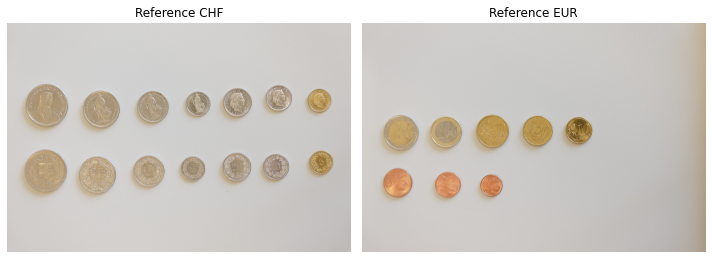

In [ ]:
# Define paths
path_chf = './data/ref/ref_chf.JPG'
path_eur = './data/ref/ref_eur.JPG'

# Load images
img_ref_chf = np.array(Image.open(path_chf))
img_ref_eur = np.array(Image.open(path_eur))

plot_chf_and_euro(img_ref_chf, img_ref_eur, 'Reference CHF', 'Reference EUR' , 'viridis')

### Load Data

In [ ]:
# load data
sample_submission = pd.read_csv("data/sample_submission.csv")
train_labels = pd.read_csv("data/train_labels.csv")

# display data 
display(sample_submission.head())
display(train_labels.head())

,id,5CHF,2CHF,1CHF,0.5CHF,0.2CHF,0.1CHF,0.05CHF,2EUR,1EUR,0.5EUR,0.2EUR,0.1EUR,0.05EUR,0.02EUR,0.01EUR,OOD
0,L0000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,L0000001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,L0000002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,L0000003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,L0000004,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,id,5CHF,2CHF,1CHF,0.5CHF,0.2CHF,0.1CHF,0.05CHF,2EUR,1EUR,0.5EUR,0.2EUR,0.1EUR,0.05EUR,0.02EUR,0.01EUR,OOD
0,L1010281,0,0,0,0,2,3,1,0,0,0,0,0,2,0,0,0
1,L1010298,0,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0
2,L1010321,0,0,1,2,0,0,0,1,2,0,2,1,0,0,0,0
3,L1010310,0,0,1,1,0,0,1,2,0,1,0,0,0,1,0,0
4,L1010300,0,1,0,0,0,0,0,1,0,2,0,1,0,0,0,0


### Performs attention pooling with the help of the gated attention mechanism

## Image Processing

## Thresholding in RGB

In [ ]:
plot_colors_histo(
    img = img_ref_chf,
    func = extract_hsv_channels,
    labels = ["Hue", "Saturation", "Value"],
)

NameError: name 'plot_colors_histo' is not defined

### Convert to Grayscale

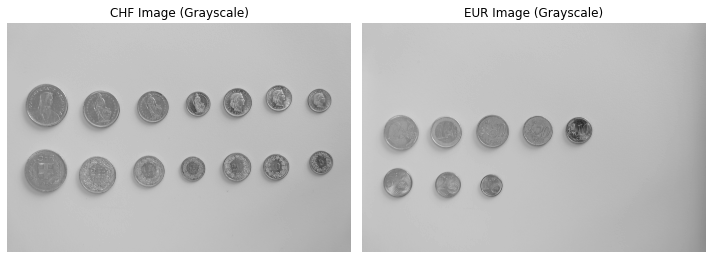

In [ ]:
# Convert images to grayscale
chf_gray = rgb2gray(img_ref_chf)
eur_gray = rgb2gray(img_ref_eur)

plot_chf_and_euro(chf_gray, eur_gray, 'CHF Image (Grayscale)', 'EUR Image (Grayscale)' , 'gray')


## Rescale the intensities to facilitate threshold selection

0.23038705882352944
1.0


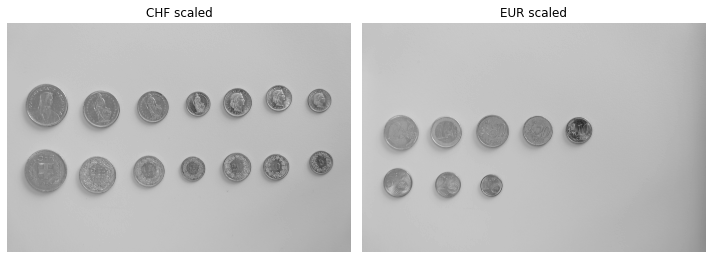

In [ ]:
# Rescale the pixel values to the range 0 to 255
chf_scaled = ((chf_gray - 0.23) / 0.77) * 255 # change those values
eur_scaled = ((eur_gray - 0.23) / 0.77) * 255

print(np.min(chf_gray))
print(np.max(chf_gray))

plot_chf_and_euro(chf_scaled, eur_scaled, 'CHF scaled', 'EUR scaled', 'gray')


### Find appropriate hsv Thresholds

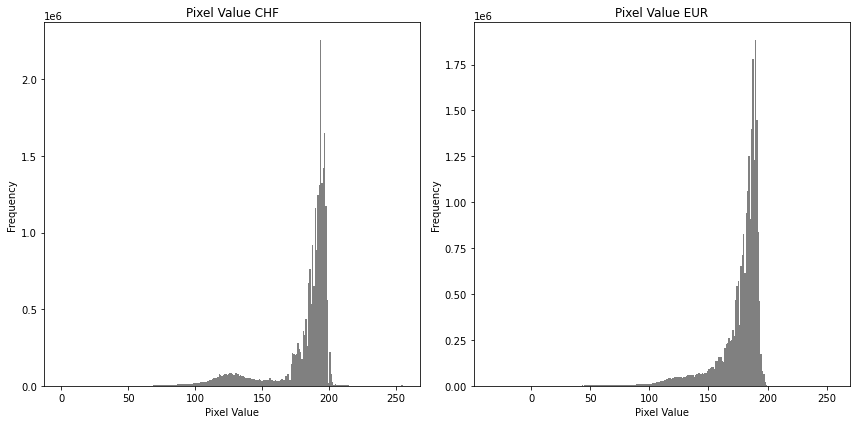

In [ ]:

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram of CHF pixel values
axs[0].hist(chf_scaled.ravel(), bins=256, range=(np.min(chf_scaled), np.max(chf_scaled)), color='gray', edgecolor='none')
axs[0].set_title('Pixel Value CHF')
axs[0].set_xlabel('Pixel Value')
axs[0].set_ylabel('Frequency')

# Plot histogram of EUR pixel values
axs[1].hist(eur_scaled.ravel(), bins=256, range=(np.min(eur_scaled), np.max(eur_scaled)), color='gray', edgecolor='none')
axs[1].set_title('Pixel Value EUR')
axs[1].set_xlabel('Pixel Value')
axs[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


### Threshold Image

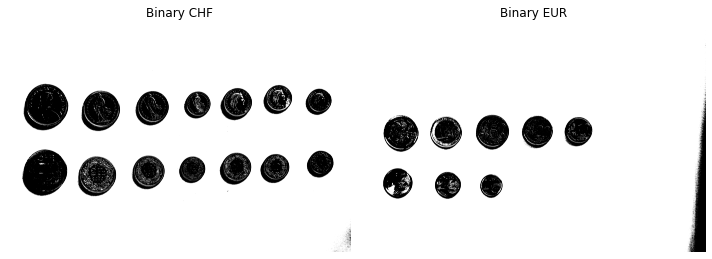

The array contains only boolean values.


In [ ]:
chf_threshold = chf_scaled > 165 # avant 150
eur_threshold = eur_scaled > 145

# Binary
#chf_threshold[chf_threshold < 150] = 256 

plot_chf_and_euro(chf_threshold, eur_threshold, "Binary CHF", 'Binary EUR', 'gray')

# Check if all elements in the array are either True or False
if np.all(np.logical_or(chf_threshold == True, chf_threshold == False)):
    print("The array contains only boolean values.")
else:
    print("The array contains non-boolean values.")


## Morphology

### Closing

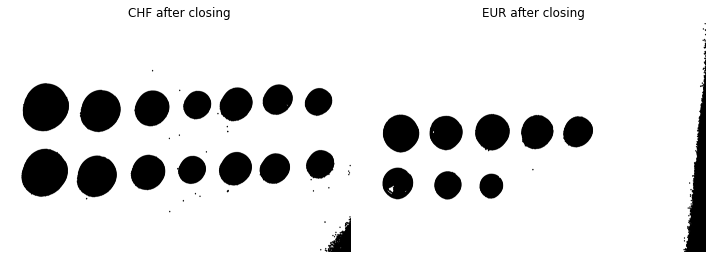

In [ ]:
#chf_closed = binary_closing(chf_threshold, disk(50))
eur_closed = binary_erosion(eur_threshold, disk(12))

chf_closed = binary_erosion(chf_threshold, disk (12))
#chf_closed = binary_dilation(chf_closed, disk(5))
# chf_closed = remove_holes(chf_closed, 15)

plot_chf_and_euro(chf_closed, eur_closed, 'CHF after closing', 'EUR after closing', 'gray')

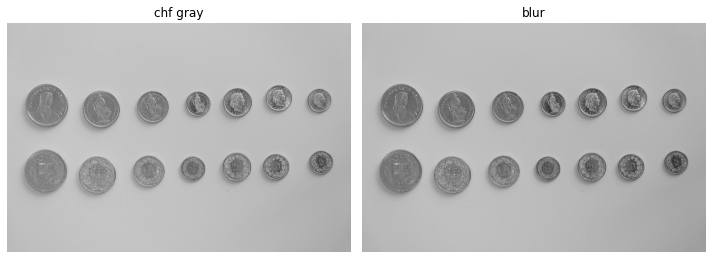

In [ ]:
# Trying edge detection

# Apply Gaussian blurring to reduce noise
gray_blur = cv2.GaussianBlur(chf_gray, (5, 5), 0)

plot_chf_and_euro(chf_gray, gray_blur, 'chf gray', 'blur', 'gray')


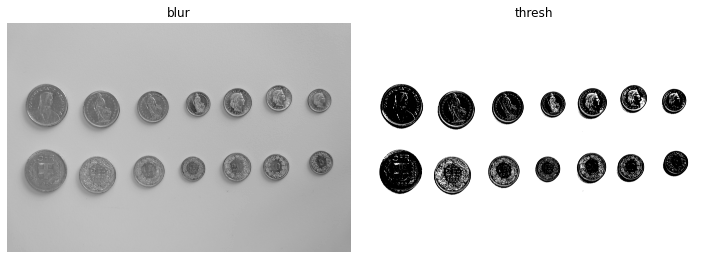

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


In [ ]:
# Threshold the image
#thresh = chf_scaled > 150 
thresh = np.where(chf_scaled > 150, 256, 0)

plot_chf_and_euro(gray_blur, thresh, 'blur', 'thresh', 'gray')


In [ ]:
#Find contours
thresh = thresh.astype(np.uint8)
contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
# THIS ONE TAKES AT LEAST 56 MINUTES TO RUN , either a prob with my ocmpu
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(chf_gray, (x, y), (x+w, y+h), (0, 255, 0), 2)

cv2.imshow('Detected Coins', chf_scaled)
cv2.waitKey(0)
cv2.destroyAllWindows()